## Vehicle Prices Prediction
Build a system that can predict the prices for vehicles using data on Vehicle specifications, make, etc. Explore the data to understand the features and figure out an approach.

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import pickle

### Custom function 

In [2]:
# Function to calculate Adjusted r2 score
def adjusted_r2_score(X, y_true, y_pred):
   
    n = X.shape[0]      # number of observations
    k = X.shape[1]      # number of independent variables

    # Calculate r2 score
    r2 = r2_score(y_true, y_pred)
    
    # Calculate adjusted r2
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

    return adj_r2

## Data Wrangling

In [3]:
# Load the data
df =pd.read_csv("vechile.csv")

# Shape of data
print(df.shape)
# Top 5 rows
df.head()

(1002, 17)


,name,description,make,model,year,price,engine,cylinders,fuel,mileage,transmission,trim,body,doors,exterior_color,interior_color,drivetrain
0,2024 Jeep Wagoneer Series II,"\n \n Heated Leather Seats, Nav Sy...",Jeep,Wagoneer,2024,74600.0,24V GDI DOHC Twin Turbo,6.0,Gasoline,10.0,8-Speed Automatic,Series II,SUV,4.0,White,Global Black,Four-wheel Drive
1,2024 Jeep Grand Cherokee Laredo,Al West is committed to offering every custome...,Jeep,Grand Cherokee,2024,50170.0,OHV,6.0,Gasoline,1.0,8-Speed Automatic,Laredo,SUV,4.0,Metallic,Global Black,Four-wheel Drive
2,2024 GMC Yukon XL Denali,NaN,GMC,Yukon XL,2024,96410.0,"6.2L V-8 gasoline direct injection, variable v...",8.0,Gasoline,0.0,Automatic,Denali,SUV,4.0,Summit White,Teak/Light Shale,Four-wheel Drive
3,2023 Dodge Durango Pursuit,White Knuckle Clearcoat 2023 Dodge Durango Pur...,Dodge,Durango,2023,46835.0,16V MPFI OHV,8.0,Gasoline,32.0,8-Speed Automatic,Pursuit,SUV,4.0,White Knuckle Clearcoat,Black,All-wheel Drive
4,2024 RAM 3500 Laramie,\n \n 2024 Ram 3500 Laramie Billet...,RAM,3500,2024,81663.0,24V DDI OHV Turbo Diesel,6.0,Diesel,10.0,6-Speed Automatic,Laramie,Pickup Truck,4.0,Silver,Black,Four-wheel Drive


In [4]:
# See the information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1002 non-null   object 
 1   description     946 non-null    object 
 2   make            1002 non-null   object 
 3   model           1002 non-null   object 
 4   year            1002 non-null   int64  
 5   price           979 non-null    float64
 6   engine          1000 non-null   object 
 7   cylinders       897 non-null    float64
 8   fuel            995 non-null    object 
 9   mileage         968 non-null    float64
 10  transmission    1000 non-null   object 
 11  trim            1001 non-null   object 
 12  body            999 non-null    object 
 13  doors           995 non-null    float64
 14  exterior_color  997 non-null    object 
 15  interior_color  964 non-null    object 
 16  drivetrain      1002 non-null   object 
dtypes: float64(4), int64(1), object(1

In [5]:
# Check for missing values
df.isnull().sum()

name                0
description        56
make                0
model               0
year                0
price              23
engine              2
cylinders         105
fuel                7
mileage            34
transmission        2
trim                1
body                3
doors               7
exterior_color      5
interior_color     38
drivetrain          0
dtype: int64

#### Comment: 
* There are some columns that contains missing values, so we will handle it later.
* There are columns like ["year", "doors", "cylinders"] in number format, it will beter if treated them categorical variable.


In [6]:
# Convert ["year", "doors", "cylinders"] to categorical variable
df[["year", "doors", "cylinders"]]=df[["year", "doors", "cylinders"]].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1002 non-null   object 
 1   description     946 non-null    object 
 2   make            1002 non-null   object 
 3   model           1002 non-null   object 
 4   year            1002 non-null   object 
 5   price           979 non-null    float64
 6   engine          1000 non-null   object 
 7   cylinders       897 non-null    object 
 8   fuel            995 non-null    object 
 9   mileage         968 non-null    float64
 10  transmission    1000 non-null   object 
 11  trim            1001 non-null   object 
 12  body            999 non-null    object 
 13  doors           995 non-null    object 
 14  exterior_color  997 non-null    object 
 15  interior_color  964 non-null    object 
 16  drivetrain      1002 non-null   object 
dtypes: float64(2), object(15)
memory 

### Work with Numerical columns

In [7]:
# See the desciptive statistics for numerical columns
df.describe()

,price,mileage
count,979.000000,968.000000
mean,50202.985700,69.033058
std,18700.392062,507.435745
min,0.000000,0.000000
25%,36600.000000,4.000000
50%,47165.000000,8.000000
75%,58919.500000,13.000000
max,195895.000000,9711.000000


#### Comment:
It seems price and milleage contanis some outliers. Let's check for it.

Text(0.5, 1.0, 'Boxplot of Price')

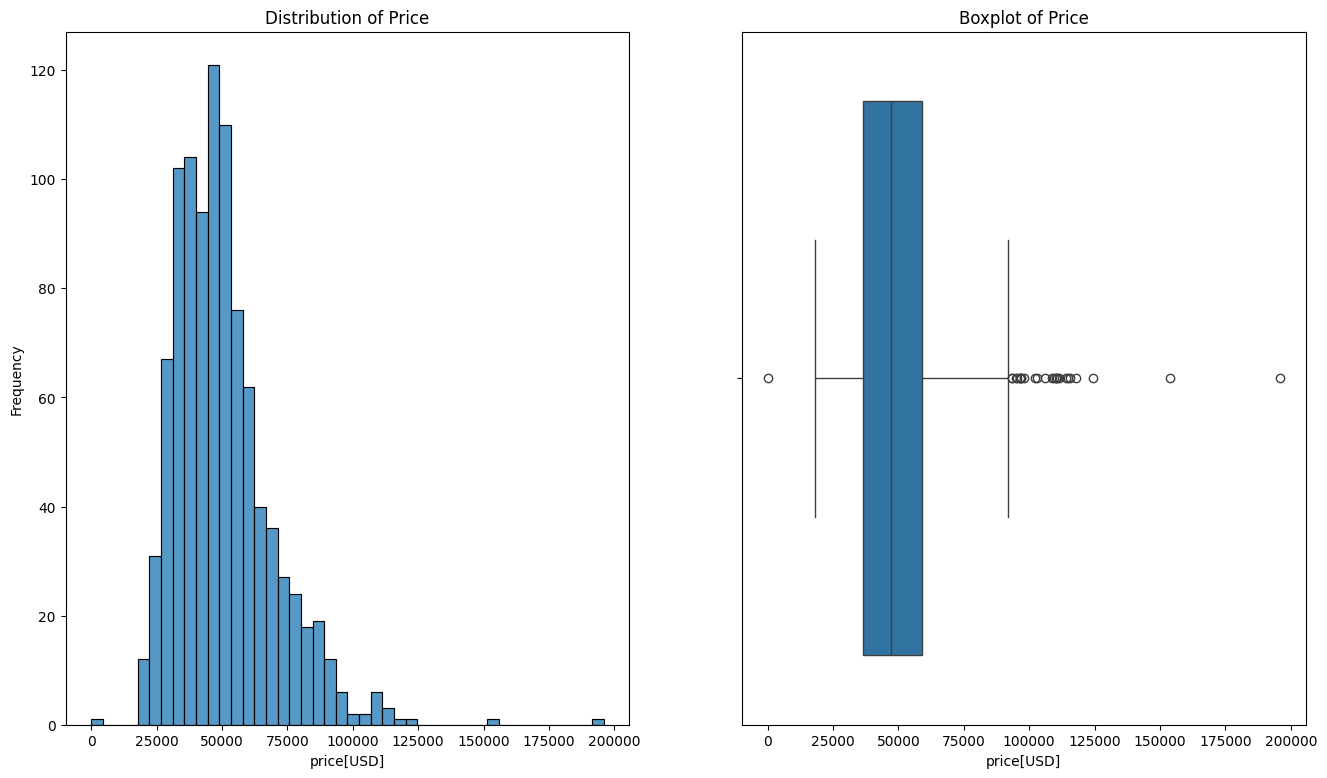

In [8]:
# Check for outlier for price
plt.figure(figsize=(16,9))

# Histogram
plt.subplot(1,2,1)
sns.histplot(df["price"])
plt.xlabel("price[USD]")
plt.ylabel("Frequency")
plt.title(f"Distribution of Price")

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(df["price"], orient='h')
plt.xlabel("price[USD]")
plt.title(f"Boxplot of Price")

#### Comment: 
There is outliers in price outside the range (20000,90000). So we should remove those outliers.

In [9]:
# Remove outliers for price
mask_price = df["price"].between(20000, 90000)
df = df[mask_price]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 0 to 1001
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            947 non-null    object 
 1   description     893 non-null    object 
 2   make            947 non-null    object 
 3   model           947 non-null    object 
 4   year            947 non-null    object 
 5   price           947 non-null    float64
 6   engine          945 non-null    object 
 7   cylinders       858 non-null    object 
 8   fuel            940 non-null    object 
 9   mileage         913 non-null    float64
 10  transmission    946 non-null    object 
 11  trim            946 non-null    object 
 12  body            944 non-null    object 
 13  doors           940 non-null    object 
 14  exterior_color  943 non-null    object 
 15  interior_color  910 non-null    object 
 16  drivetrain      947 non-null    object 
dtypes: float64(2), object(15)
memory usage:

Text(0.5, 1.0, 'Boxplot of Mileage')

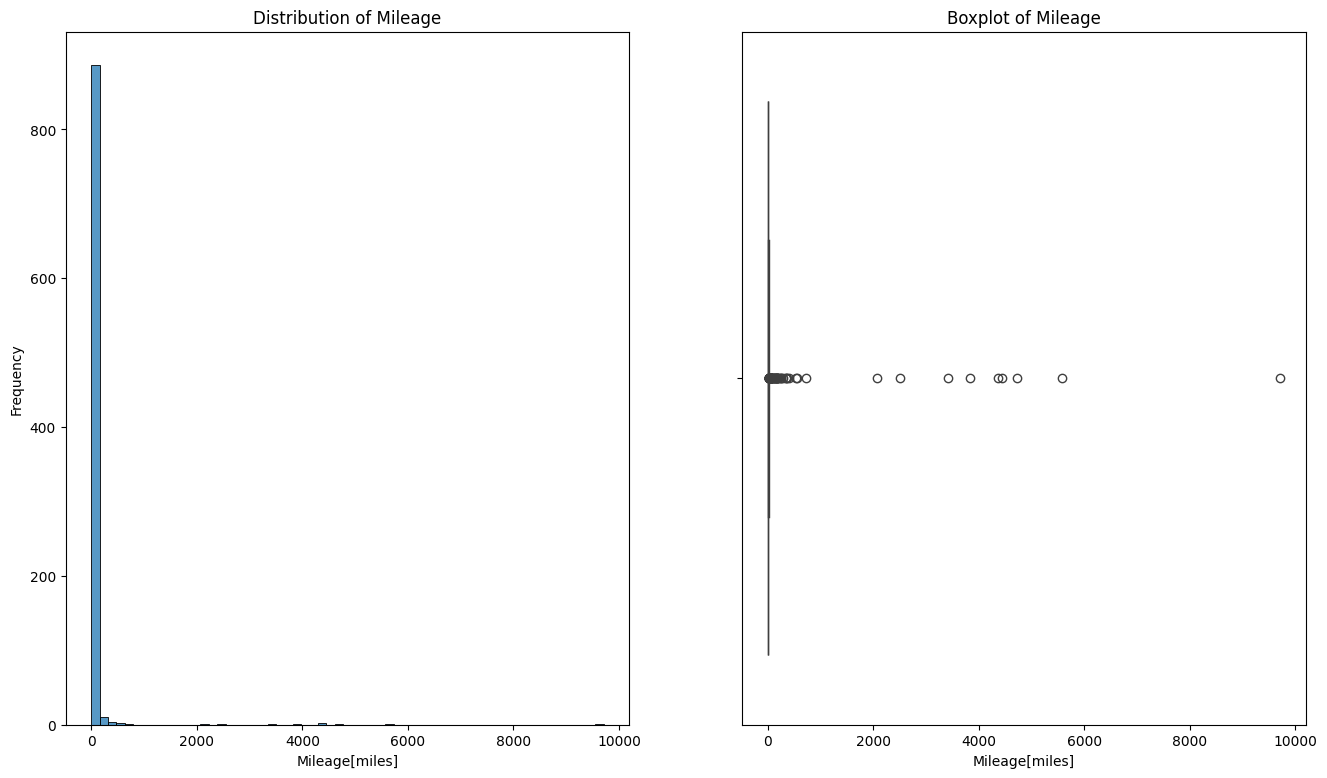

In [10]:
# Check for outlier for millage
plt.figure(figsize=(16,9))

# Histogram
plt.subplot(1,2,1)
sns.histplot(df["mileage"])
plt.xlabel("Mileage[miles]")
plt.ylabel("Frequency")
plt.title(f"Distribution of Mileage")

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(df["mileage"], orient='h')
plt.xlabel("Mileage[miles]")
plt.title(f"Boxplot of Mileage")

#### Comment:
It is clear that there is outliers in mileage approximately above 130 miles

In [11]:
# Remove outliers for mileage
mask_mileage = df["mileage"]<130
df = df[mask_mileage]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 882 entries, 0 to 1001
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            882 non-null    object 
 1   description     830 non-null    object 
 2   make            882 non-null    object 
 3   model           882 non-null    object 
 4   year            882 non-null    object 
 5   price           882 non-null    float64
 6   engine          880 non-null    object 
 7   cylinders       799 non-null    object 
 8   fuel            878 non-null    object 
 9   mileage         882 non-null    float64
 10  transmission    881 non-null    object 
 11  trim            881 non-null    object 
 12  body            879 non-null    object 
 13  doors           875 non-null    object 
 14  exterior_color  878 non-null    object 
 15  interior_color  847 non-null    object 
 16  drivetrain      882 non-null    object 
dtypes: float64(2), object(15)
memory usage:

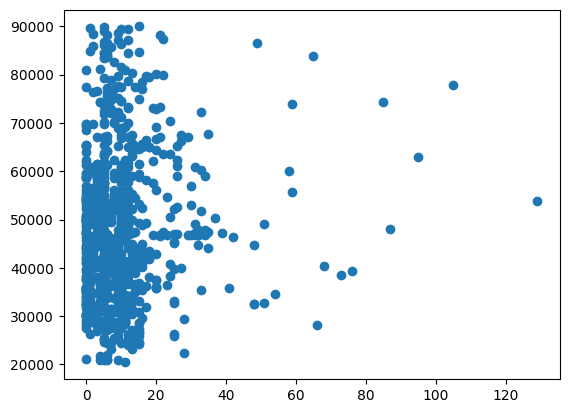

In [12]:
# Check how price depends on mileage
plt.scatter(x=df["mileage"], y=df["price"])

#### Work with Categorical data

In [13]:
# Check for cardinality
df.select_dtypes("object").nunique()

name              320
description       660
make               28
model             136
year                3
engine             95
cylinders           5
fuel                7
transmission       37
trim              187
body                8
doors               4
exterior_color    244
interior_color     81
drivetrain          4
dtype: int64

#### Comment:
* There are lot categories in each categorical variable. Column ['name', 'description'] have high cardinality and don't give us too much information. So, we can drop them.
* We will do one hot encoding for low cardinal features and target encoding for high cardinal features.
* Column 'trim' is also not contain so much information for model. So, we can remove it

In [14]:
# Drop high cardinality features
df.drop(columns=['name', 'description'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 882 entries, 0 to 1001
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   make            882 non-null    object 
 1   model           882 non-null    object 
 2   year            882 non-null    object 
 3   price           882 non-null    float64
 4   engine          880 non-null    object 
 5   cylinders       799 non-null    object 
 6   fuel            878 non-null    object 
 7   mileage         882 non-null    float64
 8   transmission    881 non-null    object 
 9   trim            881 non-null    object 
 10  body            879 non-null    object 
 11  doors           875 non-null    object 
 12  exterior_color  878 non-null    object 
 13  interior_color  847 non-null    object 
 14  drivetrain      882 non-null    object 
dtypes: float64(2), object(13)
memory usage: 110.2+ KB


## Use wrangle function
Use below wrangle function to do all above data wrangling steps

In [15]:
# Create a wrangle function
def wrangle(path):

    # Load the dataset
    df = pd.read_csv(path)

    # Convert ["year", "doors", "cylinders"] to categorical variable
    df[["year", "doors", "cylinders"]]=df[["year", "doors", "cylinders"]].astype('object')

    # Remove outliers for price and mileage
    mask_price = df["price"].between(20000, 87000)
    mask_mileage = df["mileage"]<110
    df = df[mask_price & mask_mileage]

    # Drop high cardinality and non useful features
    df.drop(columns=['name', 'description'], inplace=True)

    return df

df = wrangle("vechile.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 868 entries, 0 to 1001
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   make            868 non-null    object 
 1   model           868 non-null    object 
 2   year            868 non-null    object 
 3   price           868 non-null    float64
 4   engine          866 non-null    object 
 5   cylinders       787 non-null    object 
 6   fuel            864 non-null    object 
 7   mileage         868 non-null    float64
 8   transmission    867 non-null    object 
 9   trim            867 non-null    object 
 10  body            865 non-null    object 
 11  doors           861 non-null    object 
 12  exterior_color  864 non-null    object 
 13  interior_color  833 non-null    object 
 14  drivetrain      868 non-null    object 
dtypes: float64(2), object(13)
memory usage: 108.5+ KB


In [16]:
# Split the dataset
y = df['price']
X = df.drop('price', axis=1)

print("y shape: ", y.shape)
print("X shape: ", X.shape)

y shape:  (868,)
X shape:  (868, 14)


In [17]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (694, 14)
y_train shape:  (694,)
X_test shape:  (174, 14)
y_test shape:  (174,)


## Build the model
### Baseline model

In [18]:
baseline = [y_train.mean()]*len(y_train)
mean_absolute_error(baseline, y_train)

11577.792299578936

### Iterate 

In [19]:
# Custom transformer to get one hot encoding of each categorical features with top x categories
class TopXOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, top_x=5, columns=None):
        self.top_x = top_x
        self.columns = columns
        self.top_categories_ = {}

    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.columns)
        for col in self.columns:
            self.top_categories_[col] = (
                df[col].value_counts().nlargest(self.top_x).index.tolist()
            )
        return self

    def transform(self, X):
        df = pd.DataFrame(X, columns=self.columns)
        out = []
        for col in self.columns:
            cats = self.top_categories_[col]
            # generate one-hot array for each top cat
            arr = np.column_stack(
                [ (df[col] == cat).astype(int) for cat in cats ]
            )
            out.append(arr)
        return np.hstack(out)


In [20]:
# column groups
numeric_cols = ['mileage']
cat_cols = cat_features=df.select_dtypes(object).columns.tolist()

##  Building pipelines for each
# Numeric pipeline to handle numerical data
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


# For categorical features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('top_10_onehot', TopXOneHotEncoder(top_x=30, columns=cat_cols))
])

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num',    numeric_pipeline,    numeric_cols),
    ('cat',    cat_pipeline,     cat_cols)
])


# Final modeling pipeline
model = Pipeline([
    ('preproc', preprocessor),
    ('reg',     Lasso(max_iter=10000, tol=1e-4, random_state=42))
])

In [21]:
# Train the model
model.fit(X_train, y_train)

,steps,"[('preproc', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Evaluate

In [22]:
# Prediction with Training data
y_train_pred = model.predict(X_train)
y_train_pred[:5]

array([61184.00450971, 57646.77059133, 48478.0959099 , 49426.0585109 ,
       83655.0085354 ])

In [23]:
# Evalution
print("Training MAE: ", mean_absolute_error(y_train, y_train_pred))
print("Training RMSE: ", root_mean_squared_error(y_train, y_train_pred))
print("Training R2 Score: ", r2_score(y_train, y_train_pred))

Training MAE:  2413.1351466291926
Training RMSE:  3319.367999835471
Training R2 Score:  0.9472603110979014


### Prediction with test data

In [24]:
# Prediction
y_test_pred = model.predict(X_test)
y_test_pred[:5]

array([36780.79969636, 61818.7668117 , 62664.28172458, 47947.07130098,
       59659.71755579])

In [25]:
# Testing Evalution
print("Testing MAE: ", mean_absolute_error(y_test, y_test_pred))
print("Testing RMSE: ", root_mean_squared_error(y_test, y_test_pred))
print("Testing R2 Score: ", r2_score(y_test, y_test_pred))

Testing MAE:  3935.929226165379
Testing RMSE:  5456.717043305538
Testing R2 Score:  0.8636106839801939


## Fine-Tune the model

In [26]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define grid of parameters (value of alpha for lasso)
param_grid = {'reg__alpha': [0.5, 1, 1.5, 2, 3, 4.5, 5, 5.5, 6, 6.5, 7, 10]}

# Instantiate GridSearchCV for 5 fold cross validation
search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)

# Fit with training data
search.fit(X_train, y_train)

# Print best parameter
print("Best params:", search.best_params_)
print("Best CV R²:", search.best_score_)

Best params: {'reg__alpha': 4.5}
Best CV R²: 0.8417055431634365


In [27]:
# The best pipeline after grid search
best_model = search.best_estimator_

# The best hyperparameters and CV score
print("Best parameters:", search.best_params_)
print(f"Best CV R²:     {search.best_score_:.2f}")
print("\n\n")

## Predict on train set
y_train_pred = best_model.predict(X_train)

# Evalution
print(f"Training MAE: {mean_absolute_error(y_train, y_train_pred):.2f}")
print(f"Training RMSE: {root_mean_squared_error(y_train, y_train_pred):.2f}")
print(f"Training R2 Score: {r2_score(y_train, y_train_pred):.2f}")
print(f"Training Adjusted R2 Score: {adjusted_r2_score(X_train, y_train, y_train_pred):.2f}")
print("\n\n")

# Predict on the test set
y_test_pred = best_model.predict(X_test)

# Testing Evalution
print(f"Testing MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"Testing RMSE: {root_mean_squared_error(y_test, y_test_pred):.2f}")
print(f"Testing R2 Score: {r2_score(y_test, y_test_pred):.2f}")
print(f"Testing Adjusted R2 Score: {adjusted_r2_score(X_test, y_test, y_test_pred):.2f}")

Best parameters: {'reg__alpha': 4.5}
Best CV R²:     0.84



Training MAE: 2608.56
Training RMSE: 3519.44
Training R2 Score: 0.94
Training Adjusted R2 Score: 0.94



Testing MAE: 3932.40
Testing RMSE: 5509.45
Testing R2 Score: 0.86
Testing Adjusted R2 Score: 0.85


In [28]:
# Top 10 predicted y value and their original value for test set
pd.DataFrame({ 'Actual price': y_test, 'Predicted Price':y_test_pred.round(2)}).head(10).reset_index(drop=True)

,Actual price,Predicted Price
0,28630.0,35501.63
1,63223.0,62951.88
2,67190.0,62324.92
3,47785.0,47851.03
4,67164.0,60400.05
5,54800.0,59075.49
6,36083.0,38831.20
7,72835.0,67862.61
8,72600.0,69827.33
9,33092.0,38143.33


## Communicate result

In [29]:
model.named_steps

{'preproc': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('scaler', StandardScaler())]),
                                  ['mileage']),
                                 ('cat',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('top_10_onehot',
                                                   TopXOneHotEncoder(columns=['make',
                                                                              'model',
                                                                              'year',
                                                                              'engine',
                                                           

In [30]:
# Get the preprocessor and model
preproc = model.named_steps['preproc']
lasso   = model.named_steps['reg']

# Numeric feature names
numeric_feature_names = numeric_cols

# Categorical features after encoding
top_enc = preproc.named_transformers_['cat'].named_steps['top_10_onehot']
cat_feature_names = []
for col, cats in top_enc.top_categories_.items():
    cat_feature_names += [f"{col}_{cat}" for cat in cats]

# Combine into full feature list
feature_names = numeric_feature_names + cat_feature_names

# Get coefficients
coefficients = lasso.coef_.round(5)

# Build Series (sorted ascending by absolute value)
feat_imp = pd.Series(coefficients, index=feature_names).sort_values(key=abs)

# Top 20 features
feat_imp_20 = feat_imp.tail(20)
feat_imp_20

transmission_Variable                                               11953.52024
engine_24V GDI DOHC Twin Turbo                                      12476.87102
transmission_8 Speed Dual Clutch                                   -12790.47461
make_Land Rover                                                     12860.64660
model_Terrain                                                      -13302.56056
transmission_(CVT) CONT VAR.                                        13408.05262
make_BMW                                                            14479.74804
transmission_8-Speed Automatic with Auto-Shift                     -14901.88139
interior_color_Black Interior Color                                -15784.48316
make_RAM                                                            16384.45251
engine_16V PDI DOHC Turbo                                           17222.01893
model_Compass                                                      -17366.87657
transmission_7-Speed Automatic with Auto

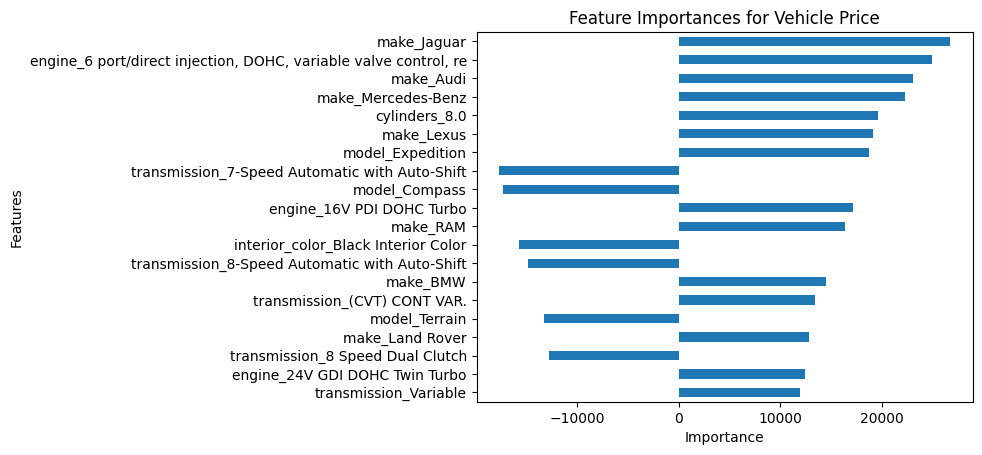

In [31]:
# Bar plot to show 20 most influencial coefficients for the model
feat_imp_20.plot(kind='barh')

# Add labels
plt.xlabel("Importance")
plt.ylabel("Features")

# Add title 
plt.title("Feature Importances for Vehicle Price");

### Save the model

In [32]:
# Save
with open('model.pkl','wb') as f:
    pickle.dump(model, f)

In [33]:
# Load the model
with open('model.pkl','rb') as f:
    loaded_model = pickle.load(f)

In [34]:
# Predict with loaded model
loaded_model.predict(X_test.iloc[:1,:])

array([36780.79969636])

In [35]:
# Actual
y_test.values[0]

np.float64(28630.0)